<a href="https://colab.research.google.com/github/taniyasinghsisodia/Deep-Learning-Projects/blob/master/Classification_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importings**

get the data from https://www.kaggle.com/competitions/nlp-getting-started/data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
#important libraries for preprocessing using NLTK
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
#from nltk.tokenize import TweetTokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
import nltk
nltk.download("punkt")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# import pandas as pd
# full_data = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
# full_data.head(5)

In [6]:
#reading of train data 
train = pd.read_csv('train.csv')
train=train[['text','target']]
train.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train.shape

(7613, 2)

# **EDA**

In [8]:
train.shape

(7613, 2)

**Randomly reading some data**

In [9]:
import random
for i in range(30):    
    j = random.randint(1,7613)
    print(train.text[j],'-----',train.target[j])
    print(' ')

My head exploded i swear ----- 0
 
@MacBreck I know what it means.It means I'll go on Twitter and obliterate any CHANCE of EVER winning another election for Pres.bad at math. ----- 0
 
#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/W0EXzAD5Gc #prebreak #best ----- 1
 
New York City Outbreak: What Is Legionnaire's Disease?   http://t.co/CXI82rFiFS ----- 1
 
Zayn Malik &amp; Perrie Edwards End Engagement: SheÛªs Û÷DevastatedÛª http://t.co/GedOxSPpL9 http://t.co/ACZRUOrYtD ----- 1
 
Did I just hear thunder? ?????? ----- 0
 
#Christians United for #Israel (#CUFI): Jews should convert soon or die by armageddon https://t.co/4aRWwRZPsr #US http://t.co/mkJQ9yfMP8 ----- 0
 
The Catastrophic Effects of Hiroshima and Nagasaki Atomic Bombings Still Being Felt Today http://t.co/WC8AqXeDF7 ----- 1
 
#Philippines Former Township fire truck being used in Philippines: Û_  of emergency equipment in Cebu Philippi...  http://t.co/aL28RVkqPQ ----- 1


In [10]:
train.target.value_counts()
#which shows the data is not unbalance 

0    4342
1    3271
Name: target, dtype: int64

Max length: 157, Min length: 7, Average Length :  101.03743596479706


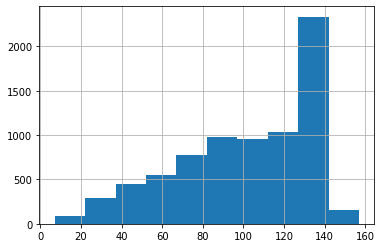

In [11]:
train['len']= train['text'].str.len()
print('Max length: {}, Min length: {}, Average Length :  {}'.format(max(train['len']),min(train['len']),train['len'].mean()))
train['len'].hist()
#as Max length: 157, Min length: 7, Average Length :  101.037 we can choose 
#- RNN
#- LSTM 
#- BILSTM

In [17]:
def unq_words(sentence):
    unq_words_list = []
    for sent in tqdm(sentence):
        for word in sent.split():
            if word.lower() not in unq_words_list:
                unq_words_list.append(word.lower())
            else:
                pass
    return unq_words_list
unique_words = unq_words(train['text'])
print("Total unique words present :",len(unique_words))

100%|██████████| 7613/7613 [00:10<00:00, 719.63it/s]

Total unique words present : 27983


In [18]:
unique_words[:20]

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 '#earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask.',
 'canada']

# **Cleaning and preprocessing**

In [19]:
#removing word starting with #
symbol_1='#'
sym1_word = [word for word in unique_words if word.startswith(symbol_1) ]
len(sym1_word)

1965

In [20]:
sym1_word[:30]

['#earthquake',
 '#wildfires',
 '#alaska',
 '#rockyfire',
 '#cafire',
 '#flood',
 '#disaster',
 '#flooding',
 '#raining',
 '#florida',
 '#tampabay',
 '#tampa',
 '#we',
 '#breaking',
 '#metal',
 '#rt',
 '#africanbaze:',
 '#mufc',
 '#bridgetown',
 '#nsfw',
 '#kurds',
 '#diyala',
 '#california',
 '#climate',
 '#energy',
 '#nowplaying:',
 '#edm',
 '#nashvilletraffic.',
 '#santaclara',
 '#bayarea']

In [21]:
#removing @ symbol
sym_2='@'
sym_word = [word for word in unique_words if word.startswith(sym_2)]
print(len(sym_word))
print(sym_word[:10])

2264
['@bbcmtd', '@phdsquares', '@southridgelife', '@\x89û_', '@navista7', '@news24680', '@nxwestmidlands', '@ablaze', '@sleepjunkies:', '@your4state.']


In [22]:
#url remover 
def url_remover(text):
    url_patterns = re.compile(r'https?://S+|www.S+')
    return url_patterns.sub(r'', text)

In [23]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [24]:
from nltk.stem import WordNetLemmatizer
import re
wl = WordNetLemmatizer()
def preprocessing(text):
    tweets = []
    for sentence in tqdm(text):
        sentence = sentence.lower() # converting the words to lower case
        sentence =  url_remover(sentence) # removing the url from the sentence
        sentence = re.sub(r'@w+',  '', sentence).strip() # removing the words starts with "@"
        sentence = re.sub("[^a-zA-Z0-9 ']", "", sentence) # removing symbols
        sentence = sentence.split()
        sentence1 = [wl.lemmatize(word) for word in sentence if word not in set(stopwords.words("english"))] #lemmatization and stopwrds removal from tweets
        sentence1 = " ".join(sentence1)
        tweets.append(sentence1)
    return tweets
tweets = preprocessing(train['text'])

100%|██████████| 7613/7613 [00:12<00:00, 629.45it/s]


In [25]:
train['clean_tweets']=tweets

In [26]:
train.head(10)

,text,target,len,clean_tweets
0,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,133,resident asked 'shelter place' notified office...
3,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire pour...
5,#RockyFire Update => California Hwy. 20 closed...,1,110,rockyfire update california hwy 20 closed dire...
6,#flood #disaster Heavy rain causes flash flood...,1,95,flood disaster heavy rain cause flash flooding...
7,I'm on top of the hill and I can see a fire in...,1,59,i'm top hill see fire wood
8,There's an emergency evacuation happening now ...,1,79,there's emergency evacuation happening buildin...
9,I'm afraid that the tornado is coming to our a...,1,52,i'm afraid tornado coming area


In [27]:
#vectorise the text
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 180
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 23060 unique tokens.


In [28]:
train.columns

Index(['text', 'target', 'len', 'clean_tweets'], dtype='object')

In [29]:
#truncate and pad the sequence 
X = tokenizer.texts_to_sequences(train['clean_tweets'].values)
X = pad_sequences(X,maxlen=MAX_SEQUENCE_LENGTH)
print('shape of tensor',X.shape)

shape of tensor (7613, 180)


In [30]:
X

array([[   0,    0,    0, ..., 1614, 4633,   81],
       [   0,    0,    0, ..., 6966, 6967, 1397],
       [   0,    0,    0, ...,  710,  670, 1101],
       ...,
       [   0,    0,    0, ...,    0,  584, 1604],
       [   0,    0,    0, ..., 1229, 2043,  330],
       [   0,    0,    0, ...,  180,  702,   62]], dtype=int32)

In [31]:
y = train['target'].to_numpy()

In [32]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [33]:
#train test split 
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6851, 180) (6851,)
(762, 180) (762,)


# **Model building**

#model-1

In [34]:
model=Sequential()

model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))


model.add(Dropout(0.2))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))


# for units in [128,128,64,32]:

#   model.add(Dense(units,activation='relu'))

#   model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 100)          5000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

# Model-2

In [ ]:
# from keras import regularizers

In [ ]:
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(LSTM(12, dropout=0.7, recurrent_dropout=0.7))
# model.add(Dense(6, kernel_regularizer=regularizers.l1_l2(0.3)))
# model.add(Dropout(0.9))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model -3

In [ ]:
# model3 = Sequential()
# model3.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model3.add(LSTM(12, dropout=0.7, recurrent_dropout=0.7))
# model3.add(Dense(128, kernel_regularizer=regularizers.l1_l2(0.3)))
# model3.add(Dropout(0.9))
# model3.add(Dense(64, kernel_regularizer=regularizers.l1_l2(0.3)))
# model3.add(Dropout(0.9))
# model3.add(Dense(32, kernel_regularizer=regularizers.l1_l2(0.3)))
# model3.add(Dropout(0.9))
# model3.add(Dense(1, activation='sigmoid'))
# model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Fitting

In [35]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
108/108 [==============================] - 34s 284ms/step - loss: 0.5881 - accuracy: 0.6768
Epoch 2/10
108/108 [==============================] - 26s 240ms/step - loss: 0.3244 - accuracy: 0.8729
Epoch 3/10
108/108 [==============================] - 26s 239ms/step - loss: 0.1858 - accuracy: 0.9329
Epoch 4/10
108/108 [==============================] - 26s 245ms/step - loss: 0.1219 - accuracy: 0.9565
Epoch 5/10
108/108 [==============================] - 27s 247ms/step - loss: 0.0875 - accuracy: 0.9675
Epoch 6/10
108/108 [==============================] - 26s 237ms/step - loss: 0.0670 - accuracy: 0.9737
Epoch 7/10
108/108 [==============================] - 26s 239ms/step - loss: 0.0539 - accuracy: 0.9769
Epoch 8/10
108/108 [==============================] - 26s 238ms/step - loss: 0.0428 - accuracy: 0.9783
Epoch 9/10
108/108 [==============================] - 27s 250ms/step - loss: 0.0412 - accuracy: 0.9785
Epoch 10/10
108/108 [==============================] - 26s 244ms/step - l

In [36]:
train_dense_results = model.evaluate(X_train,Y_train, verbose=2, batch_size=64)
valid_dense_results = model.evaluate(X_test,Y_test, verbose=2, batch_size=64)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')


108/108 - 3s - loss: 0.0486 - accuracy: 0.9783 - 3s/epoch - 28ms/step
12/12 - 0s - loss: 1.6477 - accuracy: 0.7388 - 331ms/epoch - 28ms/step
Train accuracy: 97.83
Valid accuracy: 73.88


# **Predicting on the test data**

In [37]:
test_data = pd.read_csv('test.csv')

In [38]:
test_data['text'][:10]

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
5                   We're shaking...It's an earthquake
6    They'd probably still show more life than Arse...
7                                    Hey! How are you?
8                                     What a nice hat?
9                                            Fuck off!
Name: text, dtype: object

In [39]:
new_seq = tokenizer.texts_to_sequences(test_data['text'].values)
padded = pad_sequences(new_seq,maxlen=MAX_SEQUENCE_LENGTH)
res = model.predict(padded)

102/102 [==============================] - 2s 21ms/step


In [40]:
test_data['target']=res

In [41]:
def change_val(pd_series):
  final_lis=[]
  for i in pd_series:
    if i >0.7:
      i=1
    else:
      i=0
    final_lis.append(i)
  return final_lis

target_val = change_val(test_data['target'])

In [42]:
test_data['target'] = target_val

In [43]:
test_data[['text','target']]

,text,target
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",0
2,"there is a forest fire at spot pond, geese are...",0
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,Storm in RI worse than last hurricane. My city...,0
3260,Green Line derailment in Chicago http://t.co/U...,1
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [44]:
test_data.to_csv('Result.csv')